# Import

In [ ]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import math
import random
import numpy as np
import pandas as pd
import re
from collections import defaultdict

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report

from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load Files

In [26]:
train_df = pd.read_csv("fashion-mnist_train.csv\\fashion-mnist_train.csv")
test_df = pd.read_csv("fashion-mnist_test.csv\\fashion-mnist_test.csv")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [33]:
X_train = train_df.iloc[:, 1:].values  # Pixel values
y_train = train_df.iloc[:, 0].values   # Labels
#print(X_train)
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

print(f"Training samples: {X_train.shape}, Test samples: {X_test.shape}")

Training samples: (60000, 784), Test samples: (10000, 784)


# Data Augmentation

In [27]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    transform_list = []

    if rot:
        transform_list.append(transforms.RandomRotation(rot))
    if crop:
        transform_list.append(transforms.RandomResizedCrop(28, scale=(0.9, 1.0)))
    if hflip:
        transform_list.append(transforms.RandomHorizontalFlip())
    if vflip:
        transform_list.append(transforms.RandomVerticalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean=[0.5], std=[0.5]))

    return transforms.Compose(transform_list)

We will train on 2 sets of data, the raw and the raw + augmented.

In [5]:
augment = data_augmentation(rot=25, crop=True, hflip=True, vflip=True)

# Augmentation loop
X_aug = []
y_aug = []

for i in range(len(X_train)):
    # Prepare raw image
    img_array = X_train[i].reshape(28, 28).astype(np.uint8)
    img = Image.fromarray(img_array)

    # Apply transform
    transformed = augment(img)  # Tensor: (1, 28, 28), normalized [-1, 1]
    transformed_np = transformed.numpy().squeeze()  # Shape (28, 28)

    # Convert to flat array
    X_aug.append(transformed_np.flatten())
    y_aug.append(y_train[i])

# Combine original and augmented data
scaler = StandardScaler()
X_train_combined = np.vstack([X_train, X_aug])
y_train_combined = np.hstack([y_train, y_aug])

print(f"After augmentation: {X_train_combined.shape}, {y_train_combined.shape}")

After augmentation: (120000, 784), (120000,)


# Check Data

In [6]:
#print(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Before augmentation: {X_train.shape}, {y_train.shape}")
#print(X_train)

Before augmentation: (60000, 784), (60000,)


After augmentation, the new raw + augmented data has 120,000 data. 60,000 original and 60,000 augmented.

In [7]:
pd.Series(y_train_combined).value_counts()

2    12000
9    12000
6    12000
0    12000
3    12000
4    12000
5    12000
8    12000
7    12000
1    12000
dtype: int64

We look at 5 random images from the original data.

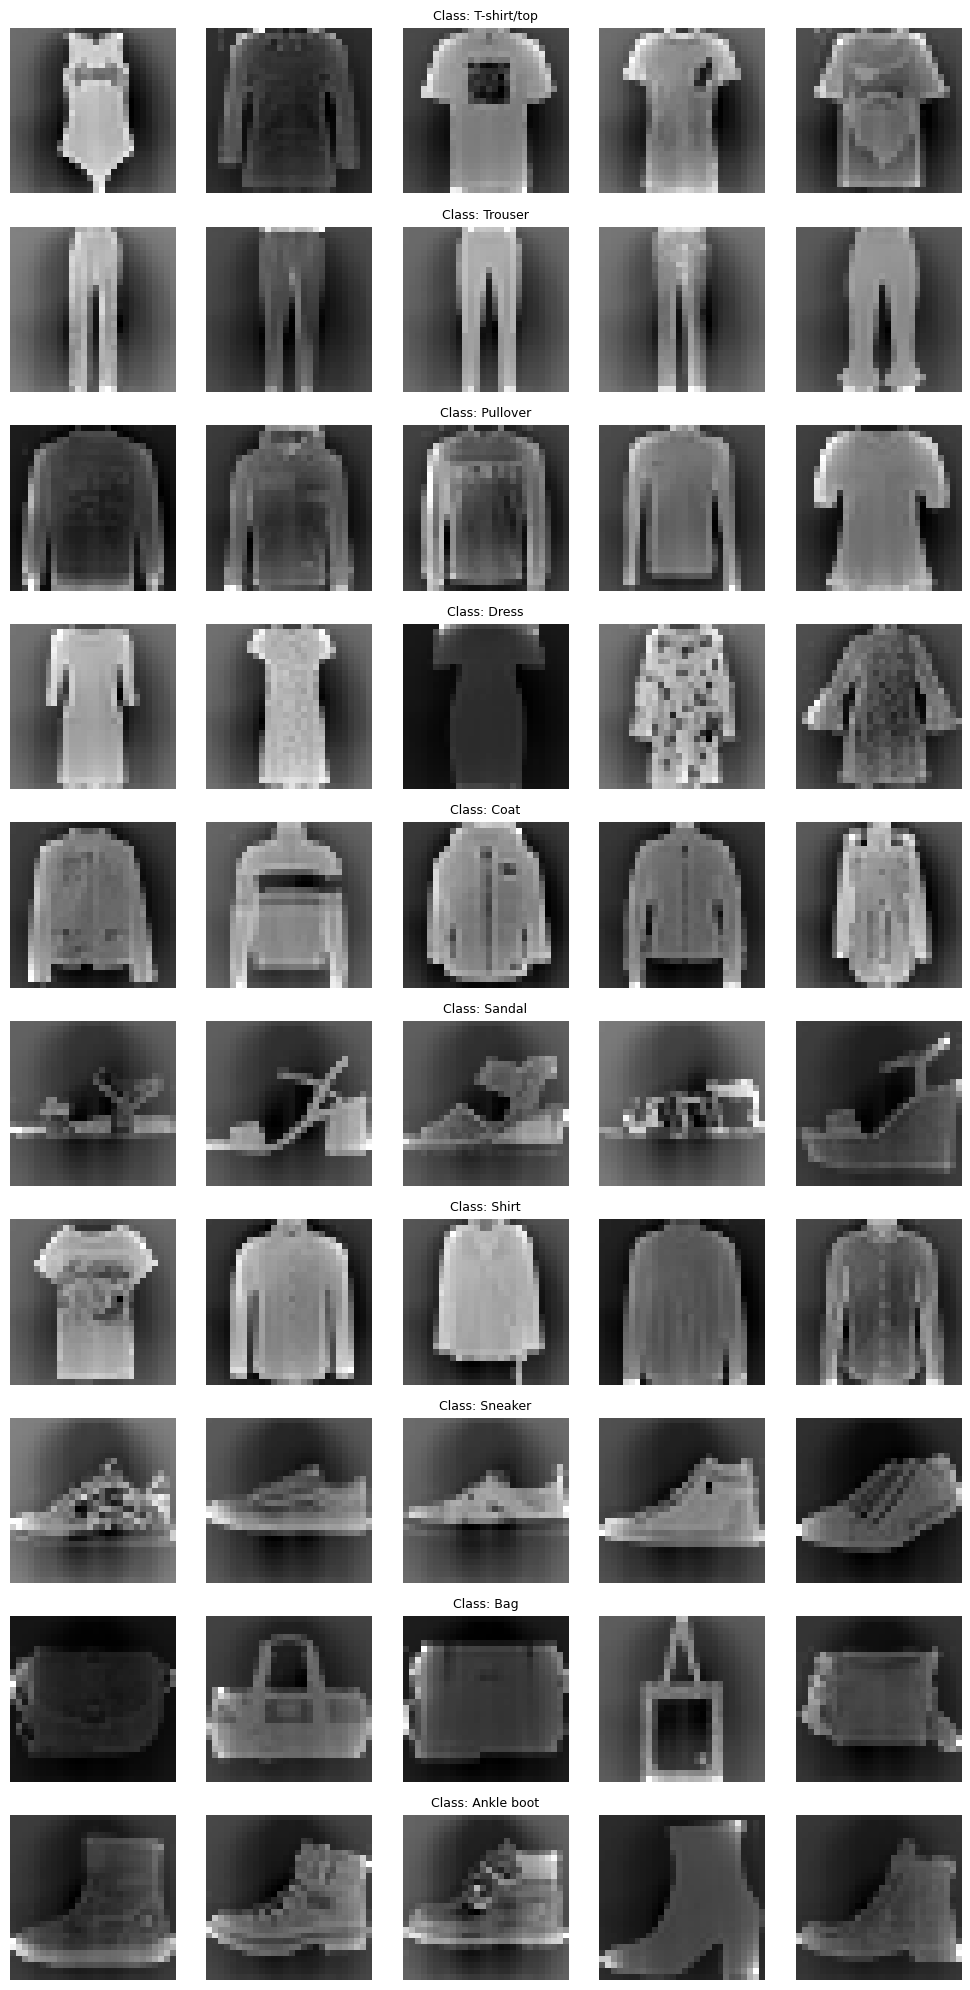

In [8]:
# 5 random ones from each class

train_labels = y_train
train_images = X_train

plt.figure(figsize=(10, 20))

for label in range(10):
    # Get all indices for current class
    class_indices = np.where(train_labels == label)[0]

    selected_indices = np.random.choice(class_indices, 5, replace=False)

    for i, idx in enumerate(selected_indices):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(train_images[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 2:
            plt.title(f"Class: {class_names[label]}", fontsize=9)

plt.tight_layout()
plt.show()

We look at 5 random images from the new data. There is a mix of raw data and augmented data.

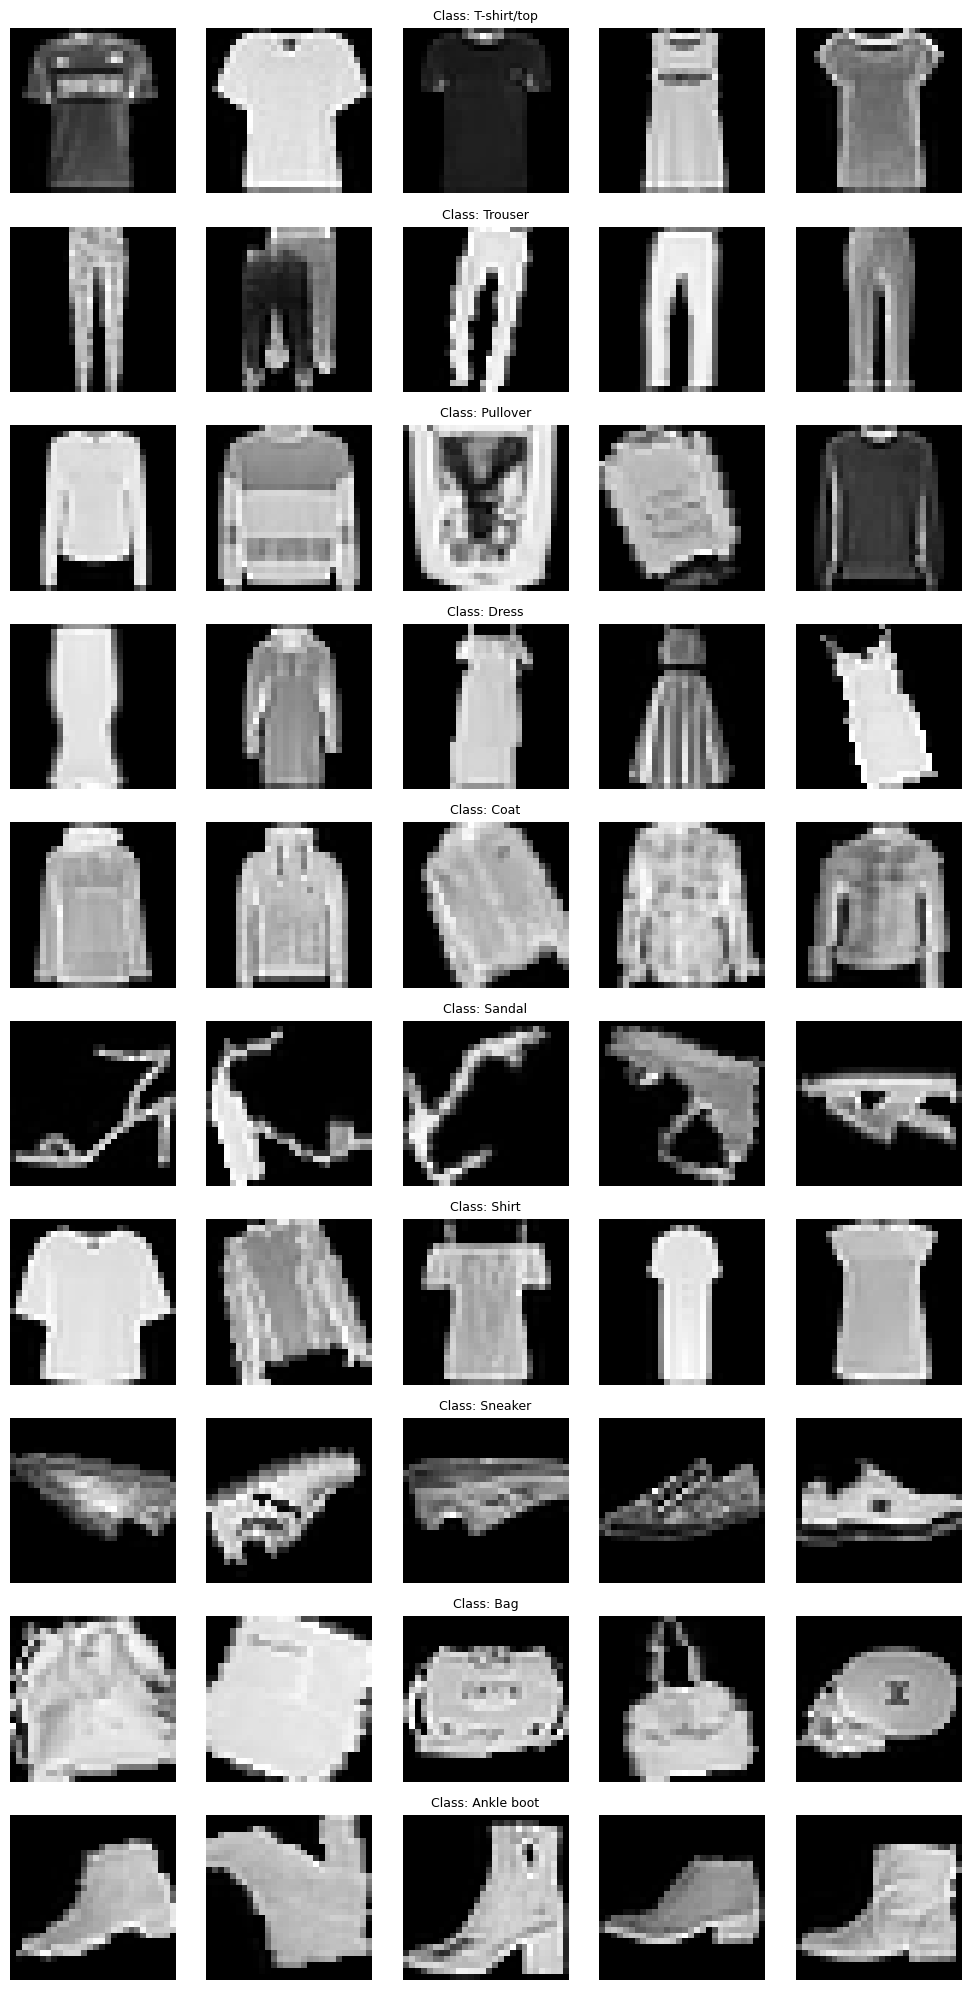

In [29]:
# 5 random ones from each class

train_labels = y_train_combined   
train_images = X_train_combined  

plt.figure(figsize=(10, 20))

for label in range(10):
    # Get all indices for current class
    class_indices = np.where(train_labels == label)[0]

    selected_indices = np.random.choice(class_indices, 5, replace=False)

    for i, idx in enumerate(selected_indices):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(train_images[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 2:
            plt.title(f"Class: {class_names[label]}", fontsize=9)

plt.tight_layout()
plt.show()

# Training

We will be training both raw and augmented data using euclidean distances. We will vary and find an optimal k.
We will also try other distances if time allows.

In [41]:
'''
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_train, y_train)

train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)

print(f"KNN Training Accuracy: {train_acc:.4f}")
print(f"KNN Test Accuracy: {test_acc:.4f}")
'''
metrics = ['manhattan']
other_metrics = ['cosine', 'chebyshev', 'euclidean']

In [ ]:
output_file = "knn_results_manhattan.txt"
with open(output_file, "w") as f:
    f.write("k\tTrain_Acc\tTest_Acc\n")
    f.write("-" * 50 + "\n")
    f.flush()
    for metric in metrics:
        f.write(f"\nTesting distance metric: {metric}\n")      
        print(metric)
        for k in range(1, 16):
            print("KNN: ", k)
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            y_train_pred = knn.predict(X_train)
            y_test_pred = knn.predict(X_test)

            # Accuracy
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            report = classification_report(y_test, y_test_pred, target_names=class_names)
            print(train_acc, test_acc)
            print(report)
            f.write(f"k = {k:2d} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}\n")
            f.write(report + "\n")
            f.write("=" * 60 + "\n")
            f.flush()
        print(f"[✓] Completed metric: {metric}")

manhattan
KNN:  1
1.0 0.8584
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.84      0.80      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.74      0.77      0.75      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.78      0.75      0.76      1000
      Sandal       0.99      0.90      0.94      1000
       Shirt       0.63      0.61      0.62      1000
     Sneaker       0.91      0.94      0.93      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.91      0.97      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

KNN:  2
0.9301666666666667 0.8563
              precision    recall  f1-score   support

 T-shirt/top       0.71      0.93      0.80      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover   

In [35]:
output_file_aug = "knn_results_augmented.txt"
with open(output_file_aug, "w") as f:
    f.write("k\tTrain_Acc\tTest_Acc\n")
    f.write("-" * 50 + "\n")
    f.flush()
    for metric in metrics:
        f.write(f"\nTesting distance metric: {metric}\n")      
        print(metric)
        for k in range(2, 16):
            print("KNN: ", k)
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train_combined, y_train_combined)
            y_train_pred = knn.predict(X_train_combined)
            y_test_pred = knn.predict(X_test)

            # Accuracy
            train_acc = accuracy_score(y_train_combined, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            report = classification_report(y_test, y_test_pred, target_names=class_names)
            print(train_acc, test_acc)
            print(report)
            f.write(f"k = {k:2d} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}\n")
            f.write(report + "\n")
            f.write("=" * 60 + "\n")
            f.flush()
        print(f"[✓] Completed metric: {metric}")

euclidean
KNN:  2
0.907225 0.853
              precision    recall  f1-score   support

 T-shirt/top       0.71      0.91      0.79      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.68      0.84      0.75      1000
       Dress       0.88      0.87      0.87      1000
        Coat       0.79      0.73      0.76      1000
      Sandal       0.98      0.90      0.94      1000
       Shirt       0.76      0.47      0.58      1000
     Sneaker       0.89      0.96      0.93      1000
         Bag       0.99      0.94      0.96      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

KNN:  3
0.8898583333333333 0.8584
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.87      0.80      1000
     Trouser       0.99      0.97      0.98      1000
    Pullove

0.8333416666666666 0.8542
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.87      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.91      0.88      0.90      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.99      0.78      0.88      1000
       Shirt       0.66      0.58      0.62      1000
     Sneaker       0.85      0.94      0.89      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.88      0.97      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

KNN:  14
0.832 0.8548
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.88      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.76      0